<img src="../images/logos/wradlib_logo.svg.png" width=250 alt="wradlib logo png" align="left"></img>

# wradlib - clutter and beamblockage

---

## Overview

Within this notebook, we will cover:

1. Reading data using xradar
1. Clutter detection
1. Beam Blockage calculation

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Xarray Basics](https://tutorial.xarray.dev/intro.html) | Helpful | Basic Dataset/DataArray |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | Basic Plotting |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Projections |

- **Time to learn**: 10 minutes

---

## Imports

In [1]:
import numpy as np
import wradlib as wrl
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xradar as xd
import hvplot
import hvplot.xarray

## retrieve data from s3 bucket


In [2]:
import os
import urllib.request
from pathlib import Path

# Set the URL for the cloud
URL = "https://js2.jetstream-cloud.org:8001/"
path = "pythia/radar/erad2024"
!mkdir -p data
files = [
    "20240522_MeteoSwiss_ARPA_Lombardia/Data/Xband/DES_VOL_RAW_20240522_1600.nc",
    "wradlib/desio_dem.tif",
]
for file in files:
    file_remote = os.path.join(path, file)
    file_local = os.path.join("data", Path(file).name)
    if not os.path.exists(file_local):
        print(f"downloading, {file_local}")
        urllib.request.urlretrieve(f"{URL}{file_remote}", file_local)

downloading, data/DES_VOL_RAW_20240522_1600.nc


downloading, data/desio_dem.tif


## Open CfRadial1 Volume


In [3]:
reindex = dict(angle_res=1, direction=1, start_angle=0, stop_angle=360)
dtree = xd.io.open_cfradial1_datatree("data/DES_VOL_RAW_20240522_1600.nc")
display(dtree.load())

DataTree('root', parent=None)
│   Dimensions:              (sweep: 8, frequency: 1)
│   Coordinates:
│     * frequency            (frequency) float32 4B 9.339e+09
│   Dimensions without coordinates: sweep
│   Data variables: (12/13)
│       sweep_fixed_angle    (sweep) float32 32B 0.7 1.3 3.0 5.0 7.0 10.0 15.0 25.0
│       sweep_group_name     (sweep) <U9 288B 'sweep_0.0' ... 'sweep_7.0'
│       volume_number        float64 8B 1.0
│       platform_type        |S32 32B b'fixed'
│       primary_axis         |S32 32B b'axis_z'
│       status_str           |S1 1B b''
│       ...                   ...
│       time_coverage_start  |S32 32B b'2024-05-22T16:00:47Z'
│       time_coverage_end    |S32 32B b'2024-05-22T16:03:20Z'
│       latitude             float64 8B 45.63
│       longitude            float64 8B 9.196
│       altitude             float64 8B 241.0
│       altitude_agl         float64 8B 35.0
│   Attributes: (12/14)
│       Conventions:         CF-1.7
│       version:             CF-Radial-1.4
│       title:               VOL_A
│       institution:         
│       references:          Conversion software: Radx::SigmetRadxFile
│       source:              Sigmet IRIS software
│       ...                  ...
│       site_name:           Desio_Radar
│       scan_name:           VOL_A
│       scan_id:             0
│       platform_is_mobile:  false
│       ray_times_increase:  true
│       history:             Wed May 22 16:32:28 2024: ncap2 -Os fixed_angle  (:)...
├── DataTree('radar_parameters')
│       Dimensions:                   ()
│       Data variables:
│           radar_antenna_gain_h      float32 4B nan
│           radar_antenna_gain_v      float32 4B nan
│           radar_beam_width_v        float32 4B 0.95
│           radar_beam_width_h        float32 4B 0.95
│           radar_receiver_bandwidth  float32 4B nan
├── DataTree('radar_calibration')
│       Dimensions:                   ()
│       Data variables: (12/55)
│           time                      |S32 32B b'2024-05-22T16:00:47Z'
│           pulse_width               timedelta64[ns] 8B 00:00:00.000044
│           xmit_power_h              float32 4B 56.01
│           xmit_power_v              float32 4B 56.01
│           two_way_waveguide_loss_h  float32 4B nan
│           two_way_waveguide_loss_v  float32 4B nan
│           ...                        ...
│           zdr_correction            float32 4B 0.0
│           ldr_correction_h          float32 4B 0.0
│           ldr_correction_v          float32 4B 0.0
│           system_phidp              float32 4B 0.0
│           test_power_h              float32 4B nan
│           test_power_v              float32 4B nan
├── DataTree('georeferencing_correction')
├── DataTree('sweep_0')
│       Dimensions:                    (azimuth: 360, range: 416)
│       Coordinates:
│           time                       (azimuth, range) datetime64[ns] 1MB 2024-05-22...
│         * range                      (range) float32 2kB 150.0 450.0 ... 1.246e+05
│         * azimuth                    (azimuth) float32 1kB 0.0412 1.027 ... 359.0
│           elevation                  (azimuth) float32 1kB 0.7031 0.7059 ... 0.7031
│           latitude                   float64 8B 45.63
│           longitude                  float64 8B 9.196
│           altitude                   float64 8B 241.0
│       Data variables: (12/30)
│           sweep_fixed_angle          float32 4B 0.7
│           sweep_number               float64 8B 0.0
│           sweep_mode                 <U20 80B 'azimuth_surveillance'
│           prt_mode                   |S32 32B b'fixed'
│           follow_mode                |S32 32B b'none'
│           ray_n_gates                (azimuth) float64 3kB 416.0 416.0 ... 416.0 416.0
│           ...                         ...
│           PHIDP                      (azimuth, range) float32 599kB 41.02 ... nan
│           HCLASS                     (azimuth, range) float32 599kB 106.0 ... nan
│           MCSSX      

# Get first sweep

In [4]:
swp = (
    dtree["sweep_0"]
    .to_dataset()
    .wrl.georef.georeference(crs=wrl.georef.get_earth_projection())
    .set_coords("sweep_mode")
)
swp.x.attrs = xd.model.get_longitude_attrs()
swp.y.attrs = xd.model.get_latitude_attrs()

In [5]:
display(swp)

<xarray.Dataset> Size: 13MB
Dimensions:                    (azimuth: 360, range: 416)
Coordinates: (12/15)
    sweep_mode                 <U20 80B 'azimuth_surveillance'
    time                       (azimuth, range) datetime64[ns] 1MB 2024-05-22...
  * range                      (range) float32 2kB 150.0 450.0 ... 1.246e+05
  * azimuth                    (azimuth) float32 1kB 0.0412 1.027 ... 359.0
    elevation                  (azimuth) float32 1kB 0.7031 0.7059 ... 0.7031
    latitude                   float64 8B 45.63
    ...                         ...
    y                          (azimuth, range) float64 1MB 45.63 ... 46.75
    z                          (azimuth, range) float64 1MB 243.0 ... 2.685e+03
    gr                         (azimuth, range) float64 1MB 0.001349 ... 1.121
    rays                       (azimuth, range) float32 599kB 0.0412 ... 359.0
    bins                       (azimuth, range) float32 599kB 150.0 ... 1.246...
    crs_wkt                    int64 8B 0
Data variables: (12/29)
    sweep_fixed_angle          float32 4B 0.7
    sweep_number               float64 8B 0.0
    prt_mode                   |S32 32B b'fixed'
    follow_mode                |S32 32B b'none'
    ray_n_gates                (azimuth) float64 3kB 416.0 416.0 ... 416.0 416.0
    ray_start_index            (azimuth) float64 3kB 1.452e+05 ... 1.448e+05
    ...                         ...
    PHIDP                      (azimuth, range) float32 599kB 41.02 ... nan
    HCLASS                     (azimuth, range) float32 599kB 106.0 ... nan
    MCSSX                      (azimuth, range) float32 599kB 2.0 2.0 ... nan
    WIDTH                      (azimuth, range) float32 599kB 0.42 0.42 ... nan
    DBZ                        (azimuth, range) float32 599kB 16.41 ... nan
    VEL                        (azimuth, range) float32 599kB 4.17 4.17 ... nan

## Get Digital Elevation Map (DEM)

If we have access to the NASA EarthData GESDISC, we can use the BearerToken to retrieve SRTM data corresponding to the actual radar domain. Or we can choose the precompiled GeoTiff.

In [6]:
# extent = [swp.x.min().values, swp.x.max().values, swp.y.min().values, swp.y.max().values]
# import os
# os.environ["WRADLIB_EARTHDATA_BEARER_TOKEN"] = ""
# dem = wrl.io.get_srtm(extent)
# wrl.io.write_raster_dataset("desio_dem.tif", dem)

In [7]:
dem = (
    xr.open_dataset("data/desio_dem.tif", engine="rasterio")
    .isel(band=0)
    .rename(band_data="DEM")
    .reset_coords("band", drop=True)
)
display(dem)

<xarray.Dataset> Size: 69MB
Dimensions:      (x: 4801, y: 3601)
Coordinates:
  * x            (x) float64 38kB 7.0 7.001 7.002 7.003 ... 11.0 11.0 11.0 11.0
  * y            (y) float64 29kB 47.0 47.0 47.0 47.0 ... 44.0 44.0 44.0 44.0
    spatial_ref  int64 8B ...
Data variables:
    DEM          (y, x) float32 69MB ...

# Extract radar parameters

In [8]:
radar_parameters = dtree["radar_parameters"]

In [9]:
bw = radar_parameters["radar_beam_width_h"]
bw

<xarray.DataArray 'radar_beam_width_h' ()> Size: 4B
array(0.95000005, dtype=float32)
Attributes:
    long_name:   half_power_radar_beam_width_h_channel
    units:       degrees
    meta_group:  radar_parameters

## Prepare DEM for Polar Processing

Here the power of [xr.apply_ufunc](https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html) is shown, a wrapper to xarray-ify numpy functions.

In [10]:
def interpolate_dem(obj, dem, **kwargs):
    dim0 = obj.wrl.util.dim0()

    def wrapper(sx, sy, dx, dy, dem, *args, **kwargs):
        y, x = np.meshgrid(dy, dx)
        rastercoords = np.dstack([x, y])
        polcoords = np.dstack([sx, sy])
        return wrl.ipol.cart_to_irregular_spline(rastercoords, dem, polcoords, **kwargs)

    out = xr.apply_ufunc(
        wrapper,
        obj.x,
        obj.y,
        dem.x,
        dem.y,
        dem,
        input_core_dims=[[dim0, "range"], [dim0, "range"], ["x"], ["y"], ["y", "x"]],
        output_core_dims=[[dim0, "range"]],
        dask="parallelized",
        vectorize=True,
        kwargs=kwargs,
        dask_gufunc_kwargs=dict(allow_rechunk=True),
    )
    out.name = "DEM"
    return obj.assign(DEM=out)

In [11]:
swp = interpolate_dem(swp, dem.DEM, order=3, prefilter=False)

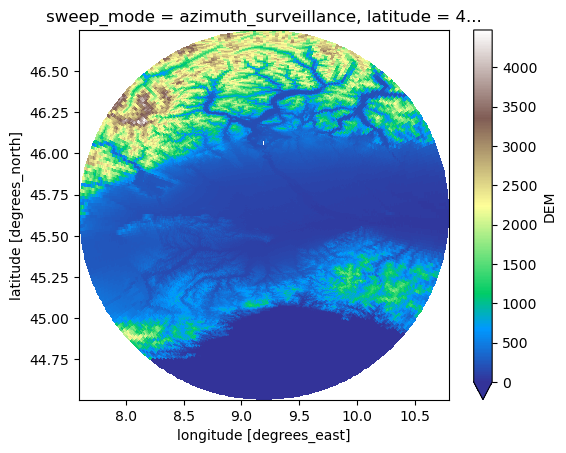

In [12]:
swp.DEM.wrl.vis.plot(cmap="terrain", vmin=0)

## Plot scan strategy

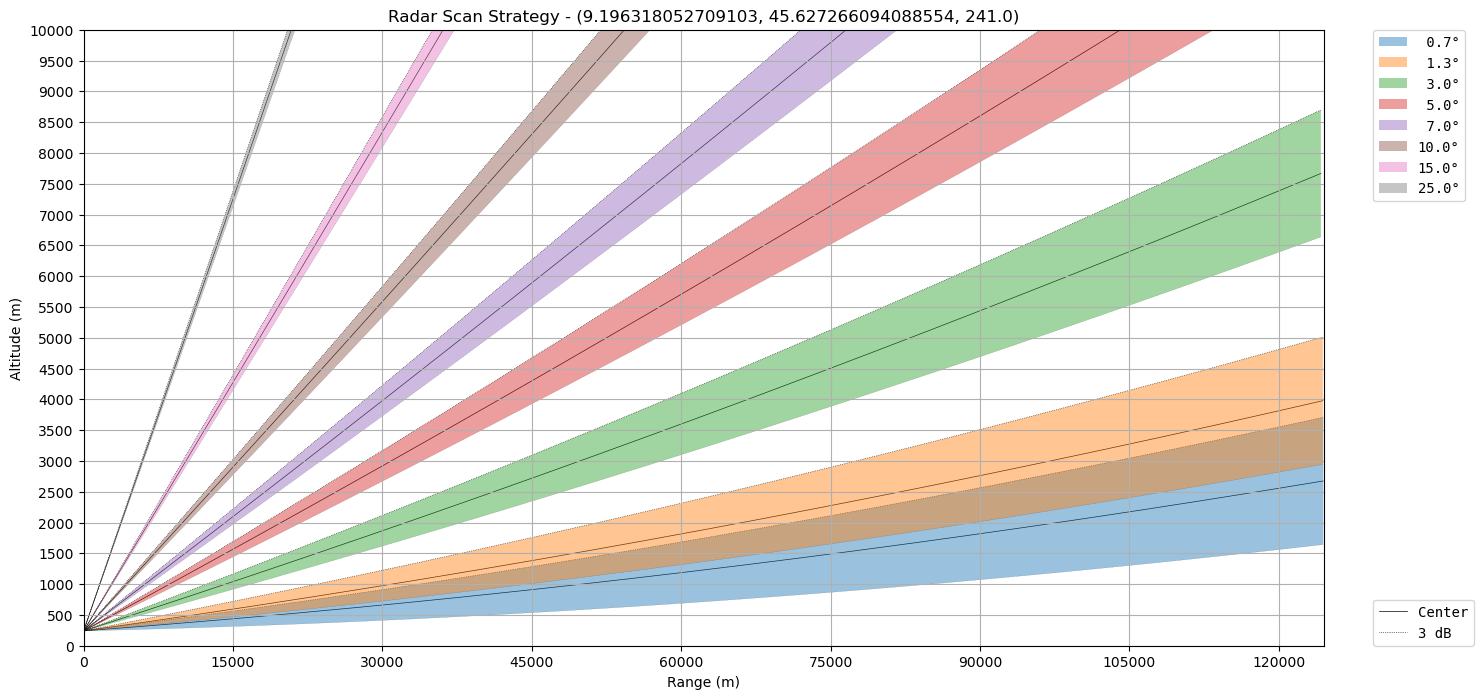

In [13]:
nrays = swp.azimuth.size
nbins = swp.range.size
range_res = 300.0
ranges = np.arange(nbins) * range_res
elevs = dtree.root.sweep_fixed_angle.values
sitecoords = (
    dtree.root.longitude.values.item(),
    dtree.root.latitude.values.item(),
    dtree.root.altitude.values.item(),
)

ax = wrl.vis.plot_scan_strategy(
    ranges,
    elevs,
    sitecoords,
    beamwidth=radar_parameters["radar_beam_width_h"].values,
    terrain=None,
)

Use `terrain=swp.DEM.sel(azimuth=0, method="nearest")` to get some arbitrary ray.

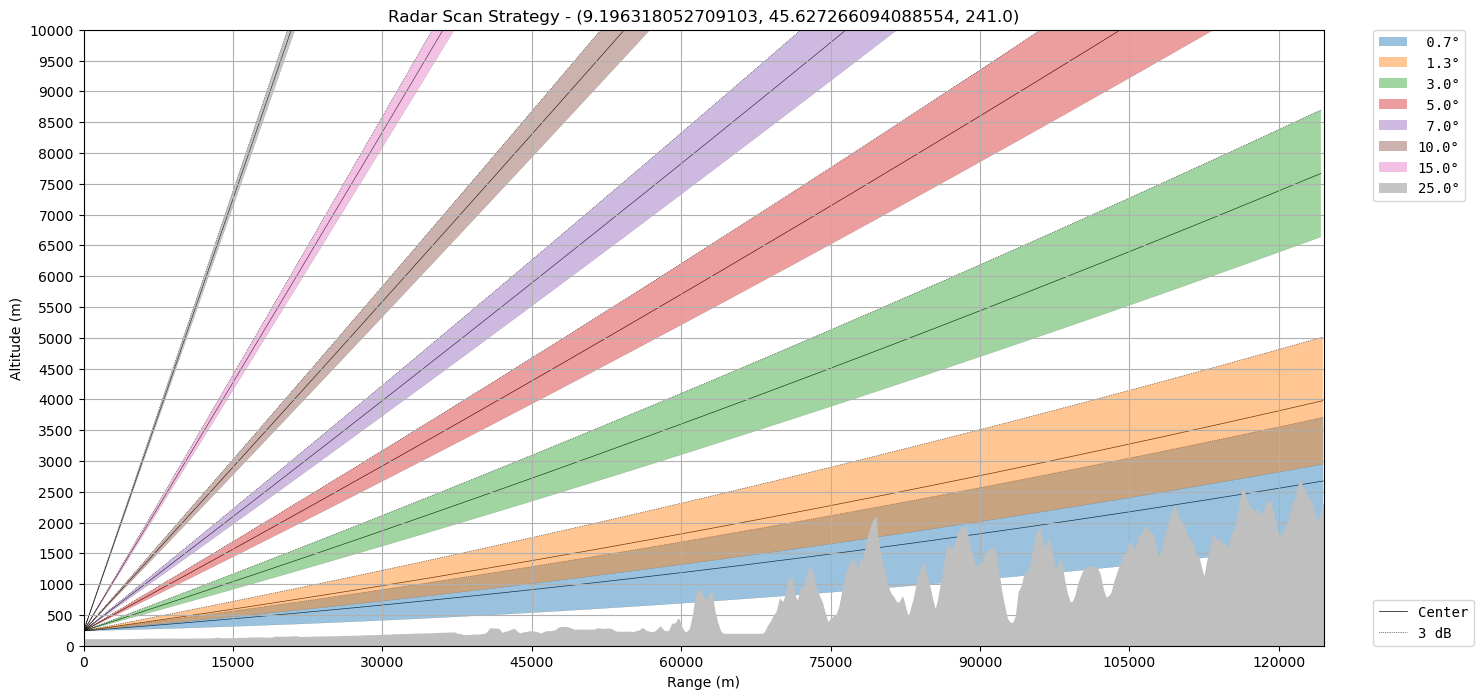

In [14]:
ax = wrl.vis.plot_scan_strategy(
    ranges,
    elevs,
    sitecoords,
    beamwidth=radar_parameters["radar_beam_width_h"].values,
    terrain=swp.DEM.sel(azimuth=0, method="nearest"),
)

## Calculate clutter map

In [15]:
clmap = swp.DBZ_TOT.wrl.classify.filter_gabella(
    wsize=5,
    thrsnorain=0.0,
    tr1=21.0,  # 21.,
    n_p=23.0,  # 23,
    tr2=1.3,
    rm_nans=False,
)
swp = swp.assign({"CMAP": clmap})

## Plot Reflectivities, Clutter and Cluttermap

Text(0.5, 1.0, 'Reflectivity clutter removed')

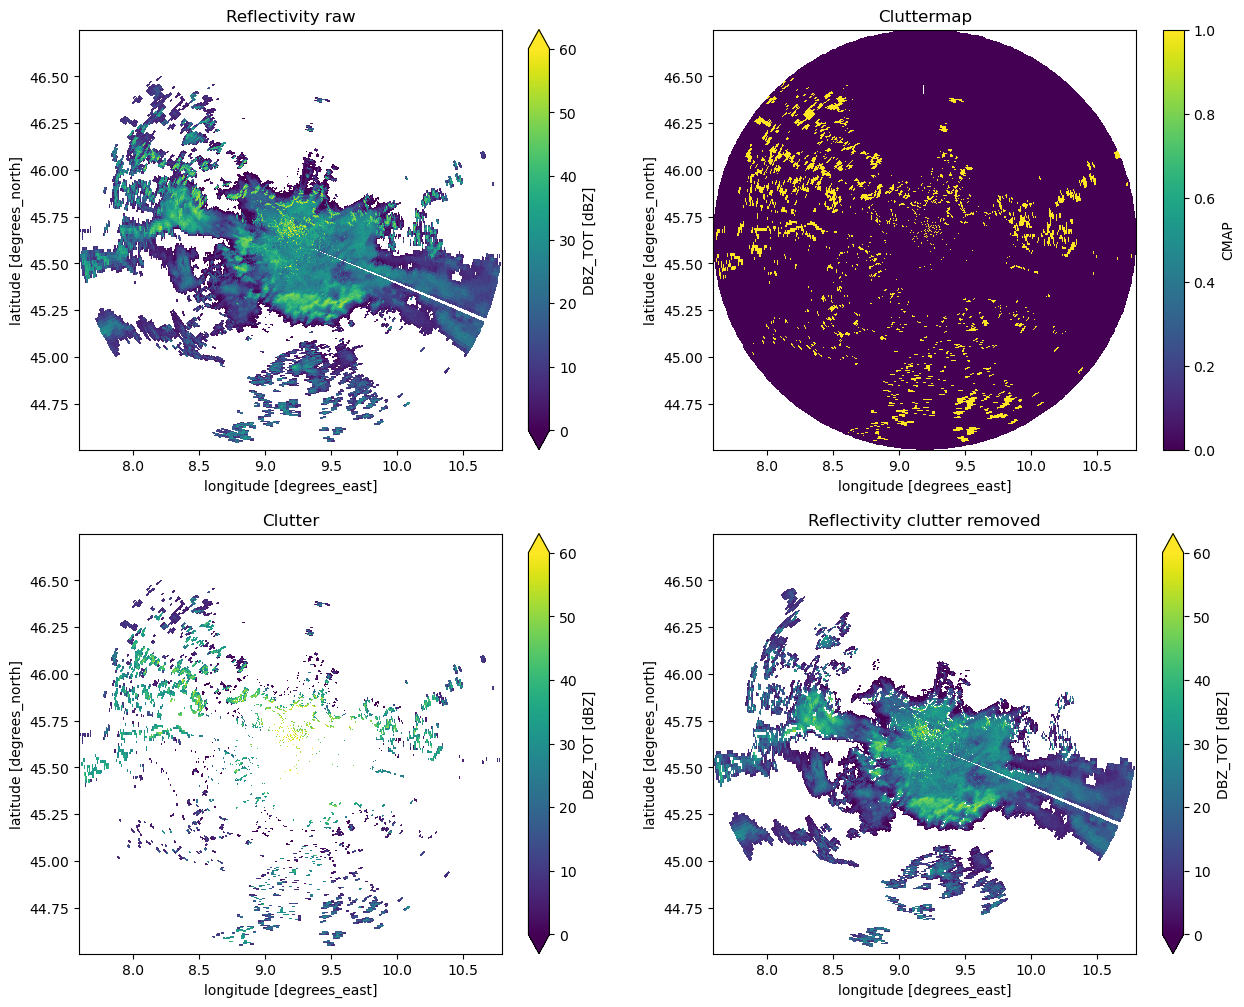

In [16]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(221)
from osgeo import osr

wgs84 = osr.SpatialReference()
wgs84.ImportFromEPSG(4326)
# swp = swp.sel(range=slice(0, 100000)).set_coords("sweep_mode").wrl.georef.georeference(crs=wgs84)
swp.DBZ_TOT.plot(x="x", y="y", ax=ax1, vmin=0, vmax=60)
ax1.set_title("Reflectivity raw")
ax2 = fig.add_subplot(222)
swp.CMAP.plot(x="x", y="y", ax=ax2)
ax2.set_title("Cluttermap")
ax3 = fig.add_subplot(223)
swp.DBZ_TOT.where(swp.CMAP == 1).plot(x="x", y="y", ax=ax3, vmin=0, vmax=60)
ax3.set_title("Clutter")
ax4 = fig.add_subplot(224)
swp.DBZ_TOT.where(swp.CMAP < 1).plot(x="x", y="y", ax=ax4, vmin=0, vmax=60)
ax4.set_title("Reflectivity clutter removed")

# Compare with corrected reflectivity from signal processor 

plus additional simple RHOHV filter

Text(0.5, 1.0, 'Reflectivity clutter removed')

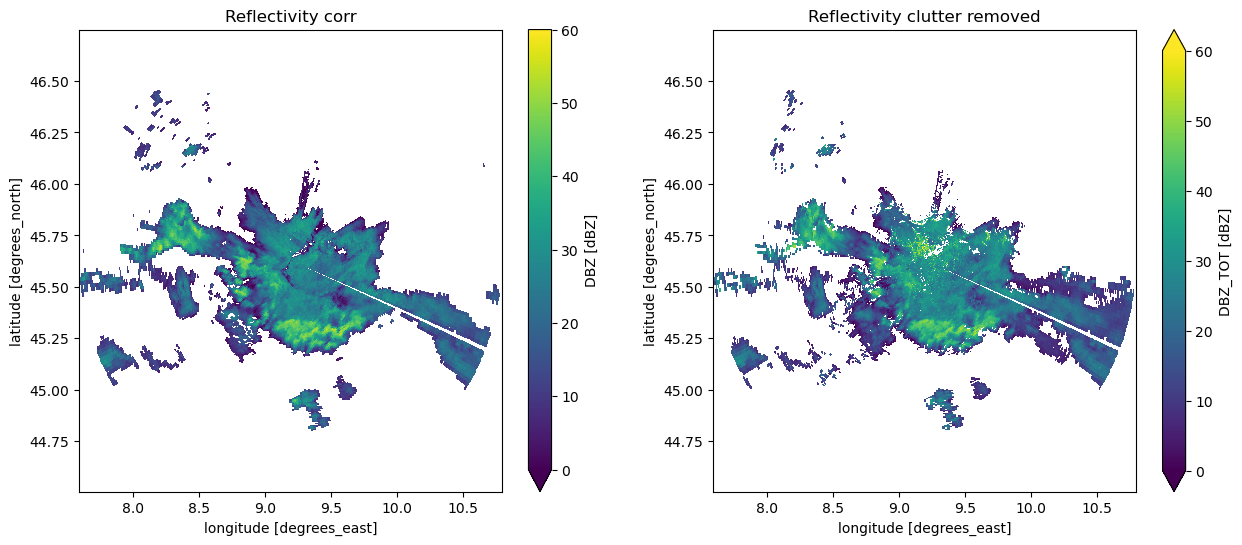

In [17]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)
swp.DBZ.plot(x="x", y="y", ax=ax1, vmin=0, vmax=60)
ax1.set_title("Reflectivity corr")
ax2 = fig.add_subplot(122)
swp.DBZ_TOT.where((swp.CMAP < 1) & (swp.RHOHV >= 0.8)).plot(
    x="x", y="y", ax=ax2, vmin=0, vmax=60
)
ax2.set_title("Reflectivity clutter removed")

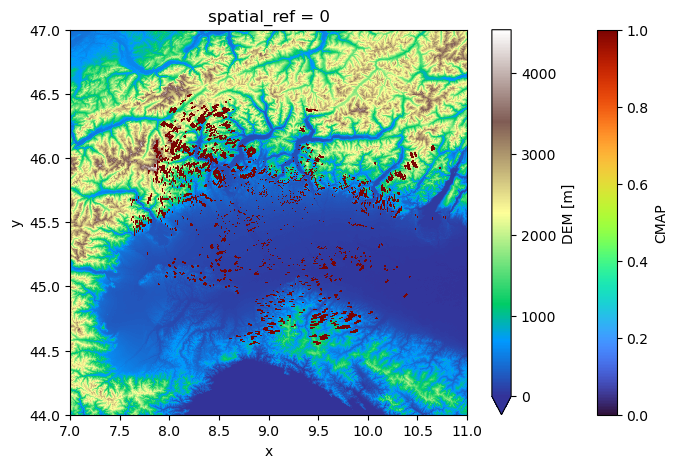

In [18]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(111)
swp.CMAP.where(swp.CMAP == 1).plot(x="x", y="y", vmin=0, vmax=1, cmap="turbo")
ax1.set_title("Reflectivity corr")
dem.DEM.plot(ax=ax1, zorder=-2, cmap="terrain", vmin=0)

# Use hvplot for zooming and panning

We need to rechunk the coordinates as hvplot needs chunked variables and coords.

In [19]:
cl = (
    swp.CMAP.where(swp.CMAP == 1)
    .chunk(chunks={})
    .hvplot.quadmesh(
        x="x", y="y", cmap="turbo", width=600, height=500, clim=(0, 1), rasterize=True
    )
)
dm = dem.DEM.chunk(chunks={}).hvplot(
    x="x", y="y", cmap="terrain", width=600, height=500, rasterize=True
)
dm * cl

:DynamicMap   []
   :Overlay
      .Image.I  :Image   [x,y]   (DEM)
      .Image.II :Image   [x,y]   (CMAP)

## BeamBlockage Calculation

Can you xarray-ify the following, too?

In [20]:
beamradius = wrl.util.half_power_radius(swp.range, bw)
PBB = wrl.qual.beam_block_frac(swp.DEM.values, swp.z.values, beamradius)
PBB = np.ma.masked_invalid(PBB)
CBB = wrl.qual.cum_beam_block_frac(PBB)

/srv/conda/envs/notebook/lib/python3.11/site-packages/wradlib/qual.py:184: RuntimeWarning: invalid value encountered in sqrt
  numer = (ya * np.sqrt(a**2 - y**2)) + (a * np.arcsin(ya)) + (np.pi * a / 2.0)
/srv/conda/envs/notebook/lib/python3.11/site-packages/wradlib/qual.py:184: RuntimeWarning: invalid value encountered in arcsin
  numer = (ya * np.sqrt(a**2 - y**2)) + (a * np.arcsin(ya)) + (np.pi * a / 2.0)


In [21]:
swp = swp.assign(
    CBB=(["azimuth", "range"], CBB),
    PBB=(["azimuth", "range"], PBB),
)

In [22]:
# just a little helper function to style x and y axes of our maps
def annotate_map(ax, cm=None, title=""):
    # ticks = (ax.get_xticks() / 1000).astype(int)
    # ax.set_xticklabels(ticks)
    # ticks = (ax.get_yticks() / 1000).astype(int)
    # ax.set_yticklabels(ticks)
    # ax.set_xlabel("Kilometers")
    # ax.set_ylabel("Kilometers")
    if not cm is None:
        plt.colorbar(cm, ax=ax)
    if not title == "":
        ax.set_title(title)
    ax.grid()

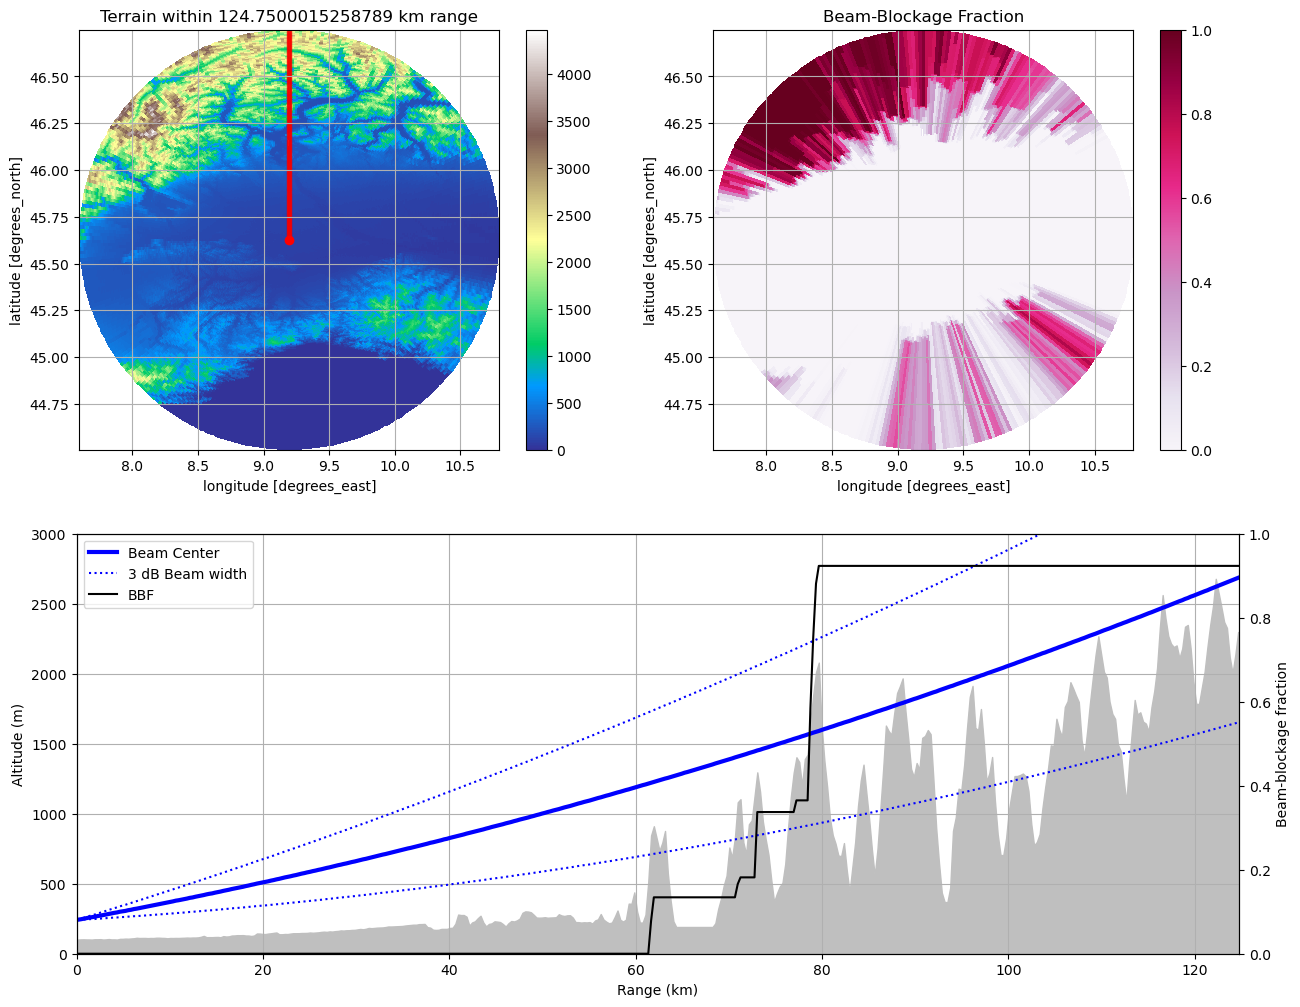

In [23]:
import matplotlib as mpl

sitecoords = (swp.longitude.values, swp.latitude.values, swp.altitude.values)
r = swp.range.values
az = swp.azimuth.values

alt = swp.z.values
fig = plt.figure(figsize=(15, 12))

# create subplots
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

# azimuth angle
angle = 0

# Plot terrain (on ax1)
dem_pm = swp.DEM.wrl.vis.plot(ax=ax1, cmap=mpl.cm.terrain, vmin=0.0, add_colorbar=False)
swp.sel(azimuth=0, method="nearest").plot.scatter(
    x="x", y="y", marker=".", color="r", alpha=0.2, ax=ax1
)
ax1.plot(swp.longitude.values, swp.latitude.values, "ro")
annotate_map(
    ax1,
    dem_pm,
    "Terrain within {0} km range".format(np.max(swp.range.values / 1000.0) + 0.1),
)

# Plot CBB (on ax2)
cbb = swp.CBB.wrl.vis.plot(ax=ax2, cmap=mpl.cm.PuRd, vmin=0, vmax=1, add_colorbar=False)
annotate_map(ax2, cbb, "Beam-Blockage Fraction")

# Plot single ray terrain profile on ax3
(bc,) = ax3.plot(
    swp.range / 1000.0, swp.z[angle, :], "-b", linewidth=3, label="Beam Center"
)
(b3db,) = ax3.plot(
    swp.range.values / 1000.0,
    (swp.z[angle, :] + beamradius),
    ":b",
    linewidth=1.5,
    label="3 dB Beam width",
)
ax3.plot(swp.range / 1000.0, (swp.z[angle, :] - beamradius), ":b")
ax3.fill_between(swp.range / 1000.0, 0.0, swp.DEM[angle, :], color="0.75")
ax3.set_xlim(0.0, np.max(swp.range / 1000.0) + 0.1)
ax3.set_ylim(0.0, 3000)
ax3.set_xlabel("Range (km)")
ax3.set_ylabel("Altitude (m)")
ax3.grid()

axb = ax3.twinx()
(bbf,) = axb.plot(swp.range / 1000.0, swp.CBB[angle, :], "-k", label="BBF")
axb.set_ylabel("Beam-blockage fraction")
axb.set_ylim(0.0, 1.0)
axb.set_xlim(0.0, np.max(swp.range / 1000.0) + 0.1)


legend = ax3.legend(
    (bc, b3db, bbf),
    ("Beam Center", "3 dB Beam width", "BBF"),
    loc="upper left",
    fontsize=10,
)

## Some EyeCandy

In [24]:
def height_formatter(x, pos):
    x = (x - 6370000) / 1000
    fmt_str = "{:g}".format(x)
    return fmt_str


def range_formatter(x, pos):
    x = x / 1000.0
    fmt_str = "{:g}".format(x)
    return fmt_str

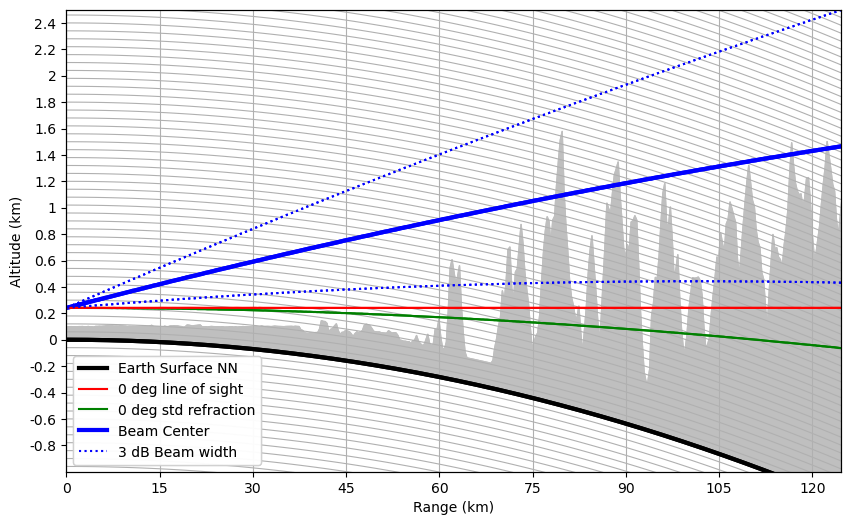

In [25]:
fig = plt.figure(figsize=(10, 6))

cgax, caax, paax = wrl.vis.create_cg(fig=fig, rot=0, scale=1)

# azimuth angle
angle = 0

# fix grid_helper
er = 6370000
gh = cgax.get_grid_helper()
gh.grid_finder.grid_locator2._nbins = 80
gh.grid_finder.grid_locator2._steps = [1, 2, 4, 5, 10]

# calculate beam_height and arc_distance for ke=1
# means line of sight
bhe = wrl.georef.bin_altitude(r, 0, sitecoords[2], re=er, ke=1.0)
ade = wrl.georef.bin_distance(r, 0, sitecoords[2], re=er, ke=1.0)
nn0 = np.zeros_like(r)
# for nice plotting we assume earth_radius = 6370000 m
ecp = nn0 + er
# theta (arc_distance sector angle)
thetap = -np.degrees(ade / er) + 90.0

# zero degree elevation with standard refraction
bh0 = wrl.georef.bin_altitude(r, 0, sitecoords[2], re=er)

# plot (ecp is earth surface normal null)
(bes,) = paax.plot(thetap, ecp, "-k", linewidth=3, label="Earth Surface NN")
(bc,) = paax.plot(thetap, ecp + alt[angle, :], "-b", linewidth=3, label="Beam Center")
(bc0r,) = paax.plot(thetap, ecp + bh0, "-g", label="0 deg Refraction")
(bc0n,) = paax.plot(thetap, ecp + bhe, "-r", label="0 deg line of sight")
(b3db,) = paax.plot(
    thetap, ecp + alt[angle, :] + beamradius, ":b", label="+3 dB Beam width"
)
paax.plot(thetap, ecp + alt[angle, :] - beamradius, ":b", label="-3 dB Beam width")

# orography
paax.fill_between(thetap, ecp, ecp + swp.DEM[angle, :], color="0.75")

# shape axes
cgax.set_xlim(0, np.max(ade))
cgax.set_ylim([ecp.min() - 1000, ecp.max() + 2500])
caax.grid(True, axis="x")
cgax.grid(True, axis="y")
cgax.axis["top"].toggle(all=False)
caax.yaxis.set_major_locator(
    mpl.ticker.MaxNLocator(steps=[1, 2, 4, 5, 10], nbins=20, prune="both")
)
caax.xaxis.set_major_locator(mpl.ticker.MaxNLocator())
caax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(height_formatter))
caax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(range_formatter))

caax.set_xlabel("Range (km)")
caax.set_ylabel("Altitude (km)")

legend = paax.legend(
    (bes, bc0n, bc0r, bc, b3db),
    (
        "Earth Surface NN",
        "0 deg line of sight",
        "0 deg std refraction",
        "Beam Center",
        "3 dB Beam width",
    ),
    loc="lower left",
    fontsize=10,
)

---

## Summary
We've just learned how to use $\omega radlib$'s Gabella clutter detection for single sweeps. We've looked into digital elevation maps and beam blockage calculations.

## Resources and references

- [xarray](https://docs.xarray.dev)
- [dask](https://docs.dask.org/)
- [GDAL](https://gdal.org)
- [xradar backends](https://docs.openradarscience.org/projects/xradar/en/stable/importers.html)
- [CfRadial1](https://ncar.github.io/CfRadial/)